<div >
<img src = "../Banner.png" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/DSEA/blob/main/Lecture13/L13_ArbolesBosques.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Tree-Based Methods

## Caso de Estudio: Prediciendo los precios de apartamentos en Airbnb

Cargamos los paquetes

In [1]:
install.packages("pacman") #run this line if you use Google Colab


The downloaded binary packages are in
	/var/folders/43/ks5b0qkj0l54138f3c8hv7jr0000gp/T//RtmpcBKuLo/downloaded_packages


In [2]:
#packages
require("pacman")
p_load("tidyverse","ggplot2","glmnet","caret","rpart","ranger")

Loading required package: pacman



## Recap

In [3]:
# Carga de datos
dta<- read_csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/refs/heads/main/airbnb_hackney.csv")

Rows: 4385 Columns: 91
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (10): f_property_type, f_room_type, f_room_type2, f_cancellation_policy,...
dbl (81): usd_price_day, n_accommodates, n_bathrooms, n_review_scores_rating...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



### Estamos simulando un examen

- Train data: Material de estudio y exámenes de práctica
- Validation (CV): Simulacros de examen para mejorar
- Test data: El examen final real

In [4]:



# Creamos un conjunto de test (30% of observations)
smp_size <- floor(0.3 * nrow(dta))

# Fijamos la semilla
set.seed(1212210)

# create ids:
# 1) seq_len: generate regular sequences
# 2) sample: select random rows from a table
test_ids <- sample(seq_len(nrow(dta)), size = smp_size)
dta$test <- 0
dta$test[test_ids] <- 1


# Validation Set
data_test <- dta %>% filter(test == 1)

#Working data set
data_train <- dta %>% filter(test == 0)



## Modelos predictivos

### 1. Regresión lineal

Comenzamos con nuestra función evaluadora.

In [5]:
predictor<-function(regresors){
  fmla<- formula(paste0("price",regresors))
  model <- lm(fmla,data = data_train)
  prediction_test <- predict(model, newdata = data_test)
  mse<-with(data_test,mean((price-prediction_test)^2))
  return(mse)
}

#### *Modelo 1 (M1):* Incluye solo la variable más básica:

-  **n\_accommodates**: número de huéspedes que el alojamiento puede recibir (variable cuantitativa, incluida linealmente).


In [6]:
modellev1 <- " ~ n_accommodates"
modellev1

[1] " ~ n_accommodates"

#### *Modelo 2 (M2):* Amplía M1 con variables básicas adicionales:
  
- **n\_accommodates**: capacidad máxima de huéspedes.
- **n\_beds**: número de camas.
- **f\_property\_type**: tipo de propiedad (apartamento, casa, habitación, etc.).
- **f\_room\_type**: tipo de habitación (entero, privado, compartido).
- **n\_days\_since**: número de días desde la primera reseña.
- **flag\_days\_since**: indicador de valor faltante en días desde la primera reseña.

In [7]:

# Basic Variables
basic_lev  <- c("n_accommodates", "n_beds", "f_property_type", "f_room_type", "n_days_since", "flag_days_since")

modellev2 <- paste0(" ~ ",paste(basic_lev,collapse = " + "))
modellev2

[1] " ~ n_accommodates + n_beds + f_property_type + f_room_type + n_days_since + flag_days_since"

#### Modelo 3 (M3): Amplía M2 con información adicional sobre características y reseñas:

- **f\_bathroom**: número de baños, convertido en variable categórica.
- **f\_cancellation\_policy**: política de cancelación (flexible, moderada, estricta, etc.).
- **f\_bed\_type**: tipo de cama (real, futón, sofá cama, etc.).
- **f\_number\_of\_reviews**: categorías del número de reseñas (0, 1–50, más de 50).
- **n\_review\_scores\_rating**: calificación promedio de reseñas.
- **flag\_review\_scores\_rating**: indicador de valor faltante en la calificación de reseñas.



In [8]:
basic_add <- c("f_bathroom","f_cancellation_policy","f_bed_type")
reviews <- c("f_number_of_reviews","n_review_scores_rating", "flag_review_scores_rating")

modellev3 <- paste0(" ~ ",paste(c(basic_lev, basic_add,reviews),collapse = " + "))
modellev3

[1] " ~ n_accommodates + n_beds + f_property_type + f_room_type + n_days_since + flag_days_since + f_bathroom + f_cancellation_policy + f_bed_type + f_number_of_reviews + n_review_scores_rating + flag_review_scores_rating"

#### *Modelo 4 (M4):* Amplía M3 incorporando no linealidades:
   
- **n\_accommodates²**: término cuadrático del número de huéspedes que puede alojar (captura convexidad o no linealidad en la relación con el precio).
- **n\_days\_since²**: término cuadrático de los días desde la primera reseña.
- **n\_days\_since³**: término cúbico de los días desde la primera reseña (para capturar relaciones no lineales más flexibles).



In [9]:
poly_lev <- c("n_accommodates2", "n_days_since2", "n_days_since3")

modellev4 <- paste0(" ~ ",paste(c(basic_lev,basic_add,reviews,poly_lev),collapse = " +"))
modellev4

[1] " ~ n_accommodates +n_beds +f_property_type +f_room_type +n_days_since +flag_days_since +f_bathroom +f_cancellation_policy +f_bed_type +f_number_of_reviews +n_review_scores_rating +flag_review_scores_rating +n_accommodates2 +n_days_since2 +n_days_since3"

#### Modelo 5 (M5): Amplía M4 introduciendo interacciones clave:
  
- **f\_room\_type × f\_property\_type**: interacción entre el tipo de habitación (entero, privado, compartido) y el tipo de propiedad (apartamento, casa, etc.).
- **f\_number\_of\_reviews × f\_property\_type**: interacción entre el número de reseñas (categorías) y el tipo de propiedad.


In [10]:
X1  <- c("f_room_type*f_property_type",  "f_room_type*d_familykidfriendly")

modellev5 <- paste0(" ~ ",paste(c(basic_lev,basic_add,reviews,poly_lev,X1),collapse = " + "))

modellev5

[1] " ~ n_accommodates + n_beds + f_property_type + f_room_type + n_days_since + flag_days_since + f_bathroom + f_cancellation_policy + f_bed_type + f_number_of_reviews + n_review_scores_rating + flag_review_scores_rating + n_accommodates2 + n_days_since2 + n_days_since3 + f_room_type*f_property_type + f_room_type*d_familykidfriendly"

#### Modelo 6 (M6): Amplía M5 introduciendo interacciones con amenidades

In [11]:
X2  <- c("d_airconditioning*f_property_type", "d_cats*f_property_type", "d_dogs*f_property_type")
modellev6 <- paste0(" ~ ",paste(c(basic_lev,basic_add,reviews,poly_lev,X1,X2),collapse = " + "))

modellev6

[1] " ~ n_accommodates + n_beds + f_property_type + f_room_type + n_days_since + flag_days_since + f_bathroom + f_cancellation_policy + f_bed_type + f_number_of_reviews + n_review_scores_rating + flag_review_scores_rating + n_accommodates2 + n_days_since2 + n_days_since3 + f_room_type*f_property_type + f_room_type*d_familykidfriendly + d_airconditioning*f_property_type + d_cats*f_property_type + d_dogs*f_property_type"

####  M6 + todas las demás *amenities*                                                                          

In [12]:
amenities <-  grep("^d_.*", names(data_train), value = TRUE)

modellev7 <- paste0(" ~ ",paste(c(basic_lev,basic_add,reviews,poly_lev,X1,X2,amenities),collapse = " + "))

modellev7

[1] " ~ n_accommodates + n_beds + f_property_type + f_room_type + n_days_since + flag_days_since + f_bathroom + f_cancellation_policy + f_bed_type + f_number_of_reviews + n_review_scores_rating + flag_review_scores_rating + n_accommodates2 + n_days_since2 + n_days_since3 + f_room_type*f_property_type + f_room_type*d_familykidfriendly + d_airconditioning*f_property_type + d_cats*f_property_type + d_dogs*f_property_type + d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet"

#### M8   = M7 + todas las demás *amenities* interactuando con otros factores

In [13]:
X3  <- c(paste0("(f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * (",
                 paste(amenities, collapse=" + "),")"))
modellev8 <- paste0(" ~ ",paste(c(basic_lev,basic_add,reviews,poly_lev,X1,X2,amenities,X3),collapse = " + "))
modellev8


[1] " ~ n_accommodates + n_beds + f_property_type + f_room_type + n_days_since + flag_days_since + f_bathroom + f_cancellation_policy + f_bed_type + f_number_of_reviews + n_review_scores_rating + flag_review_scores_rating + n_accommodates2 + n_days_since2 + n_days_since3 + f_room_type*f_property_type + f_room_type*d_familykidfriendly + d_airconditioning*f_property_type + d_cats*f_property_type + d_dogs*f_property_type + d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet + (f_property_type + f_room_type + f_cancellation_policy + f_bed_type) * (d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet)"

#### MSE de los modelos

In [14]:
model_list <- list(
  modellev1,
  modellev2,
  modellev3,
  modellev4,
  modellev5,
  modellev6,
  modellev7,
  modellev8
)

lapply(model_list,predictor)

Warning message in predict.lm(model, newdata = data_test):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(model, newdata = data_test):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


[[1]]
[1] 1237.634

[[2]]
[1] 1047.675

[[3]]
[1] 1009.28

[[4]]
[1] 1009.658

[[5]]
[1] 1001.824

[[6]]
[1] 996.8911

[[7]]
[1] 966.2763

[[8]]
[1] 1073.987

### Lasso via glmnet

In [15]:
p_load("glmnet")
 

In [16]:
X<- model.matrix(formula(modellev8),data_train)[, -1]  # Eliminar intercepto
y<- data_train$price

In [17]:

set.seed(123)  # Para reproducibilidad

# Validación cruzada con Lasso
cv_lasso <- cv.glmnet(
  x = X,
  y = y,
  alpha = 1,           # Lasso
  nfolds = 10,         # 10-fold CV (puedes cambiar a 5 si prefieres)
  type.measure = "mse" 
)


In [18]:
X_test <- model.matrix(formula(modellev8), data_test)[, -1]
y_test <- data_test$price  # Variable objetivo real en test


# Predicciones con lambda.min
pred_min <- predict(cv_lasso, newx = X_test, s = "lambda.min")
pred_min <- as.numeric(pred_min)  # Convertir a vector

# Predicciones con lambda.1se
pred_1se <- predict(cv_lasso, newx = X_test, s = "lambda.1se")
pred_1se <- as.numeric(pred_1se)



# Función para calcular múltiples métricas
calculate_metrics <- function(y_true, y_pred, model_name) {
  residuals <- y_true - y_pred
  
  metrics <- tibble(
    modelo = model_name,
    MSE = mean(residuals^2),               
  )
  
  return(metrics)
}



In [19]:
# Calcular métricas para ambos modelos
metrics_min <- calculate_metrics(y_test, pred_min, "lambda.min")
metrics_1se <- calculate_metrics(y_test, pred_1se, "lambda.1se")

In [20]:
metrics_min

modelo,MSE
<chr>,<dbl>
lambda.min,968.007


In [21]:
metrics_1se

modelo,MSE
<chr>,<dbl>
lambda.1se,974.6572


#### Comparamos

In [22]:
lapply(model_list,predictor)

Warning message in predict.lm(model, newdata = data_test):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(model, newdata = data_test):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


[[1]]
[1] 1237.634

[[2]]
[1] 1047.675

[[3]]
[1] 1009.28

[[4]]
[1] 1009.658

[[5]]
[1] 1001.824

[[6]]
[1] 996.8911

[[7]]
[1] 966.2763

[[8]]
[1] 1073.987

### Arboles con `rpart`

Usamos el paquete `rpart` para construir los arboles. Este paquete permite ajustar modelos de manera rápida y sencilla. Vamos a usar todos los regresores en niveles ya que los arboles me permiten capturar las interacciones.

In [23]:
modellev9 <- paste0(" ~ ",paste(c(basic_lev,basic_add,reviews,amenities),collapse = " + "))
modellev9

[1] " ~ n_accommodates + n_beds + f_property_type + f_room_type + n_days_since + flag_days_since + f_bathroom + f_cancellation_policy + f_bed_type + f_number_of_reviews + n_review_scores_rating + flag_review_scores_rating + d_24hourcheckin + d_airconditioning + d_breakfast + d_buzzerwirelessintercom + d_cabletv + d_carbonmonoxidedetector + d_cats + d_dogs + d_doorman + d_doormanentry + d_dryer + d_elevatorinbuilding + d_essentials + d_familykidfriendly + d_fireextinguisher + d_firstaidkit + d_freeparkingonpremises + d_freeparkingonstreet + d_gym + d_hairdryer + d_hangers + d_heating + d_hottub + d_indoorfireplace + d_internet + d_iron + d_keypad + d_kitchen + d_laptopfriendlyworkspace + d_lockonbedroomdoor + d_lockbox + d_otherpets + d_paidparkingoffpremises + d_petsallowed + d_petsliveonthisproperty + d_pool + d_privateentrance + d_privatelivingroom + d_safetycard + d_selfcheckin + d_shampoo + d_smartlock + d_smokedetector + d_smokingallowed + d_suitableforevents + d_tv + d_washer + d_washerdryer + d_wheelchairaccessible + d_wirelessinternet"

In [24]:
p_load("rpart")

formula_tree<-formula(paste0("price",modellev9))
mytree <- rpart(formula_tree,data=data_train)

In [25]:
mytree

n= 3070 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 3070 7596514.0  76.82476  
   2) f_room_type=Private room,Shared room 1592  751122.2  45.78329 *
   3) f_room_type=Entire home/apt 1478 3659057.0 110.26050  
     6) f_bathroom< 2.5 1240 1890207.0 100.35320  
      12) n_accommodates< 3.5 608  509875.2  86.03618 *
      13) n_accommodates>=3.5 632 1135812.0 114.12660  
        26) n_accommodates< 5.5 496  745341.7 108.09270 *
        27) n_accommodates>=5.5 136  306553.6 136.13240 *
     7) f_bathroom>=2.5 238 1013015.0 161.87820  
      14) n_accommodates< 5.5 145  503702.1 144.53100 *
      15) n_accommodates>=5.5 93  397648.5 188.92470 *

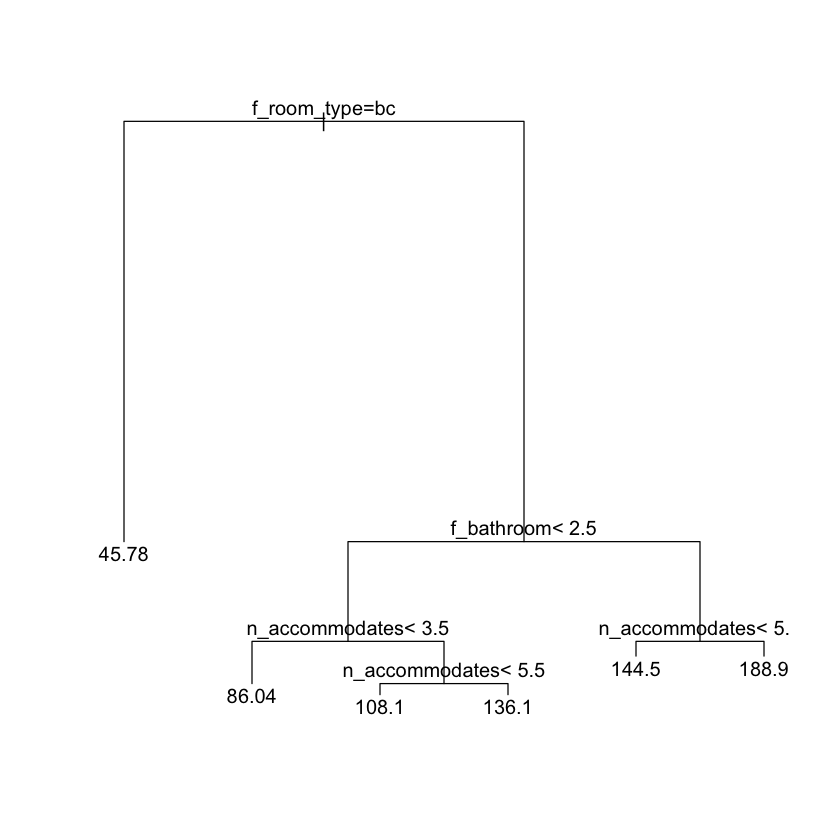

In [26]:
plot(mytree)
text(mytree)

Para visualizar árboles de decisión de forma mas "bonita", podemos usar el paquete `rpart.plot`, que extiende las capacidades de rpart con funciones gráficas más potentes y estéticas. La función principal es `prp()` qye permite crear gráficos detallados del árbol entrenado. En el siguiente ejemplo, usamos varias opciones para mejorar la presentación del árbol:

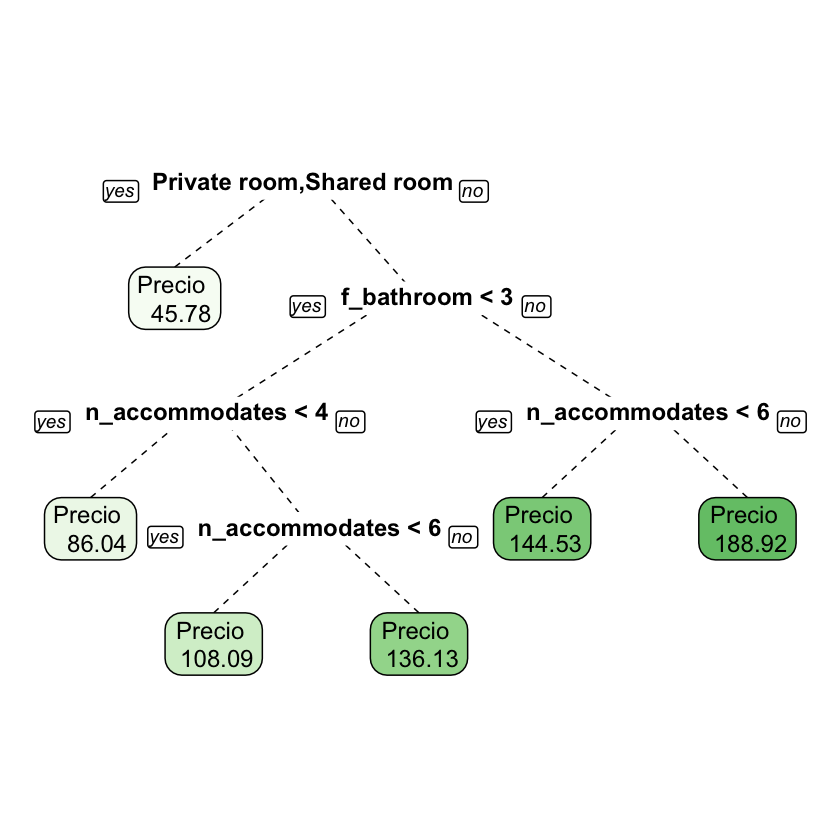

In [27]:
p_load("rpart.plot")

prp(mytree, 
    under = TRUE,              # Muestra información adicional debajo del nodo
    branch.lty = 2,            # Estilo de línea punteada para las ramas
    yesno = 2,                 # Muestra "sí/no" en las bifurcaciones
    faclen = 0,                # Muestra etiquetas completas de factores
    varlen = 15,               # Longitud máxima del nombre de la variable
    tweak = 1.2,               # Ajusta el tamaño del texto
    clip.facs = TRUE,          # Recorta niveles largos de factores
    box.palette = "Greens",    # Paleta de colores para las cajas
    compress = TRUE,           # Comprime el árbol verticalmente
    ycompress = TRUE,          # Comprime también el eje y
    node.fun = function(x, labs, digits, varlen) 
      paste("Precio \n", format(round(mytree$frame$yval, 2), nsmall=0, big.mark=","))  # Personaliza el texto del nodo
)


### Sobreajuste

<div >
<img src = "figures/tree_uba.png" width="300"/>
</div>


- Fijar la profundidad del árbol. (implementado en Caret `method=rpart2`)

- Fijar la mínima cantidad de datos que están contenidos dentro de cada hoja. 

- Cost complexity pruning (implementado en Caret con `method=rpart`)

- `tidymodels` implementa todos

##### Implementación con Caret

In [28]:
p_load("caret")

In [29]:
fitControl<-trainControl(method ="cv",
                         number=5)

#####  `method=rpart2`  allows to tune Max Tree Depth

In [30]:
set.seed(123)

tree_rpart2 <- train(
    formula_tree,
    data=data_train,
    method = "rpart2",
    trControl = fitControl,
    tuneGrid = expand.grid(maxdepth = seq(1,8,1))
)

In [31]:
tree_rpart2

CART 

3070 samples
  62 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2456, 2455, 2456, 2457, 2456 
Resampling results across tuning parameters:

  maxdepth  RMSE      Rsquared   MAE     
  1         38.10353  0.4148530  25.20726
  2         34.68099  0.5141891  23.04027
  3         33.45056  0.5486192  22.21302
  4         33.46268  0.5485446  22.22388
  5         33.39552  0.5504229  22.11031
  6         33.25206  0.5546058  21.96506
  7         33.25206  0.5546058  21.96506
  8         33.25206  0.5546058  21.96506

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was maxdepth = 6.

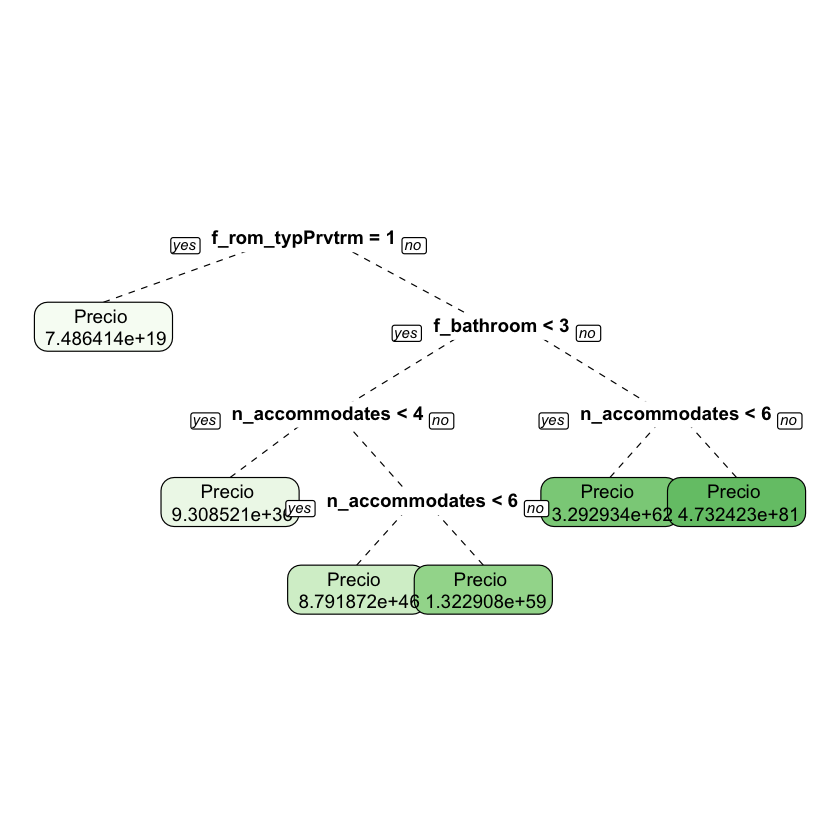

In [32]:
prp(tree_rpart2$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_rpart2$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

#### Cost complexity Prunning


Cost complexity del árbol  $T$ con $[T]$ nodos terminales del árbol 
\begin{align}
  C_{\alpha}(T)= \sum_{m=1}^{[T]}  \sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 + \alpha [T]
\end{align}


Objetivo: para un dado $\alpha$, encontrar el pruning óptimo que minimice  $C_{\alpha}(T)$

Se logra eliminando sucesivamente las ramas que producen un aumento mínimo en $\sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 $


##### Algoritmo completo

  - Hacemos crecer el árbol

  - Para un dado $\alpha$, aplicamos  *cost complexity pruning* 
    
  - Utilizamos K-fold cross-validation para elegir $\alpha$. 

  
Tenemos entonces una secuencia de subarboles para distintos valores de $\alpha$ 

Elegimos el $\alpha$ y el subárbol que tienen el menor error de predicción.

#####  `method=rpart`  only allows to tune Complexity Parameter


In [33]:
set.seed(123)
tree_lenght <- train(
    formula_tree,
    data=data_train,
    method = "rpart",
    trControl = fitControl,
    tuneLength=20
)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


In [34]:
tree_lenght

CART 

3070 samples
  62 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2456, 2455, 2456, 2457, 2456 
Resampling results across tuning parameters:

  cp           RMSE      Rsquared   MAE     
  0.002010399  33.41869  0.5544124  21.84962
  0.002027020  33.41869  0.5544124  21.84962
  0.002149962  33.30196  0.5570795  21.77036
  0.002377853  33.40622  0.5542103  21.91987
  0.002507355  33.48224  0.5516988  21.91446
  0.002520740  33.48224  0.5516988  21.91446
  0.002528578  33.42842  0.5527808  21.88674
  0.002669792  33.51389  0.5506199  21.91956
  0.002909771  33.36765  0.5536764  21.86397
  0.003181330  33.29665  0.5549680  21.86963
  0.003373991  33.18588  0.5573917  21.83011
  0.003388537  33.18588  0.5573917  21.83011
  0.004740553  32.89249  0.5638747  21.76744
  0.005393887  32.86493  0.5649080  21.72262
  0.008970696  32.94511  0.5626712  21.74664
  0.011046715  33.39552  0.5504229  22.11031
  0.014647524  33.54514  0.5458331  22.249

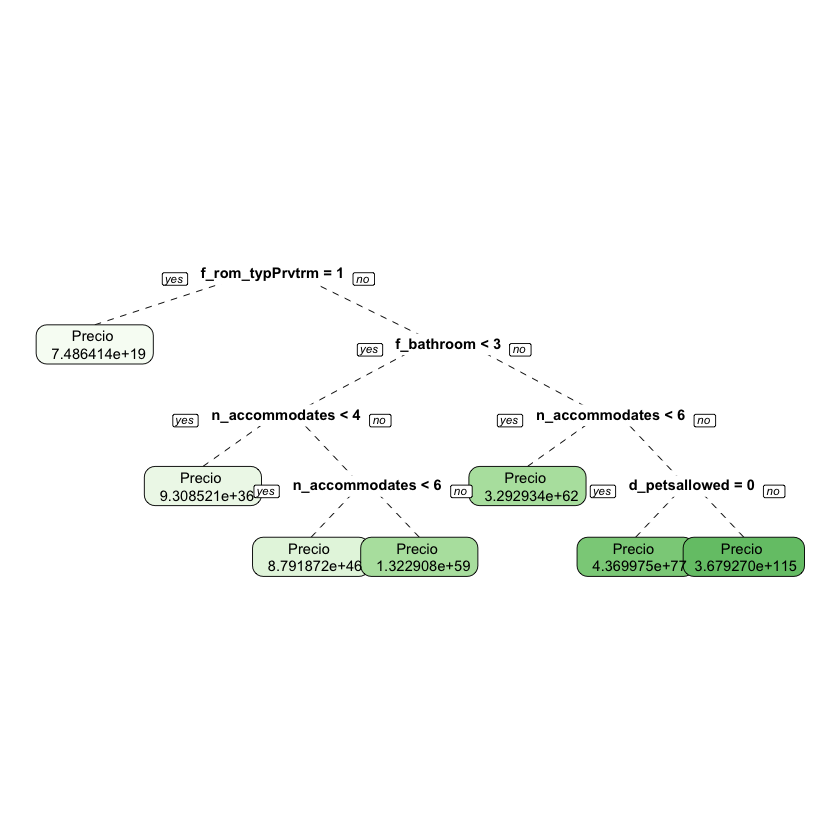

In [35]:
prp(tree_lenght$finalModel, under = TRUE, branch.lty = 2, yesno = 2, faclen = 0, varlen=15,tweak=1.2,clip.facs= TRUE,box.palette = "Greens",compress=FALSE,ycompress = FALSE,node.fun=function(x, labs, digits, varlen) paste("Precio \n", format(round(exp(tree_lenght$finalModel$frame$yval), 0), nsmall=0, big.mark=",")))

More details here: https://topepo.github.io/caret/train-models-by-tag.html#tree-based-model

## Prediction Performance

In [36]:
pred_tree_part2<-predict(tree_rpart2,data_test)

In [37]:

calculate_metrics(y_test, pred_tree_part2, "tree_rpart2")

modelo,MSE
<chr>,<dbl>
tree_rpart2,1044.813


In [38]:
pred_tree_lenght <- predict(tree_lenght, data_test) 
calculate_metrics(y_test, pred_tree_lenght, "tree_lenght")

modelo,MSE
<chr>,<dbl>
tree_lenght,1077.541


### Comentarios sobre Árboles


#### Pros: 
  
    - Los árboles son muy fáciles de explicar a las personas (probablemente incluso más fáciles que la regresión lineal). Los árboles se pueden trazar gráficamente y son fácilmente interpretados incluso por no expertos. 
    
    - Variables más importantes en la parte superior



#### Cons:
    
    - Si la estructura es lineal, CART no funciona bien
    
<div >
<img src = "figures/tree_vs_reg.png" />
</div>


    - Los árboles no son muy robustos 
    

## Bagging and Random Forests

### Con `caret` y `ranger`

Podemos entrenar estos modelos  utilizando el paquete `ranger` en combinación con `caret`, lo cual nos permite buscar automáticamente la mejor combinación de hiperparámetros mediante validación cruzada.


In [39]:
p_load("ranger")
p_load("caret")


`Caret` nos permite ajustar facilmente los siguientes hiperparámetros

- `mtry`: número de predictores seleccionados aleatoriamente en cada división.
- `splitrule`: criterio de división (en regresión, típicamente `"variance"`).
- `min.node.size`: número mínimo de observaciones en un nodo terminal.
- Falta alguno importante?

In [40]:
set.seed(123)  # Fijamos semilla para reproducibilidad

tree_ranger_grid <- train(
    formula_tree,  # Fórmula del modelo
    data = data_train,  # Dataset de entrenamiento
    method = "ranger",  # Usamos el motor ranger para Random Forests
    trControl = fitControl,  # Especificamos los controles de validación cruzada definidos antes
    tuneGrid = expand.grid(   # Definimos la grilla de hiperparámetros a explorar
        mtry = c(4,5,6),  # Número de predictores seleccionados al azar en cada división
        splitrule = "variance",  # Regla de partición basada en la reducción de varianza (regresión)
        min.node.size = c(3, 5, 30)  # Tamaño mínimo de nodos terminales
    ),
    importance = "permutation"  # Calculamos la importancia de variables por permutación
)


In [41]:
tree_ranger_grid

Random Forest 

3070 samples
  62 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 2456, 2455, 2456, 2457, 2456 
Resampling results across tuning parameters:

  mtry  min.node.size  RMSE      Rsquared   MAE     
  4      3             32.39215  0.6015247  21.42607
  4      5             32.40344  0.6023888  21.44511
  4     30             33.18452  0.5929346  22.05884
  5      3             31.81849  0.6070092  20.99383
  5      5             31.95040  0.6041788  21.08458
  5     30             32.62947  0.5967673  21.54432
  6      3             31.64720  0.6060483  20.81307
  6      5             31.63506  0.6074808  20.79067
  6     30             32.13989  0.6020256  21.18712

Tuning parameter 'splitrule' was held constant at a value of variance
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 6, splitrule = variance
 and min.node.size = 5.

Una vez entrenado el modelo, podemos examinar qué tan importantes fueron las variables explicativas en las decisiones del Random Forest. Esto nos da una idea de qué características influyen más en la predicción del precio de las viviendas.

In [42]:
varImp(tree_ranger_grid)

ranger variable importance

  only 20 most important variables shown (out of 64)

                            Overall
f_room_typePrivate room     100.000
n_accommodates               72.253
n_beds                       29.501
f_bathroom                   15.288
d_familykidfriendly           8.725
d_tv                          4.824
f_property_typeHouse          3.643
f_cancellation_policystrict   3.370
d_smokedetector               3.188
d_dryer                       2.718
d_essentials                  2.536
d_iron                        2.344
d_hairdryer                   2.320
d_elevatorinbuilding          2.310
d_lockonbedroomdoor           2.310
n_days_since                  2.236
d_buzzerwirelessintercom      2.128
d_smokingallowed              2.063
f_number_of_reviews           2.013
flag_review_scores_rating     1.998

In [43]:
predictions_rf <- predict(tree_ranger_grid, data_test)
calculate_metrics(y_test, predictions_rf, "random_forest")

modelo,MSE
<chr>,<dbl>
random_forest,897.5439
